<a href="https://colab.research.google.com/github/hdtran103/Spanish-Wine-Quality-Dataset/blob/main/Model2_Spanish_Wine_Quality_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spanish Wine Quality Dataset**

## **Libraries**

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

## **Load the dataset**

### **Number of Rows : 7500**
### **Number of Features: 10**

In [2]:
wine = pd.read_csv('/content/drive/MyDrive/wines_SPA.csv')
wine.head()
wine.info()
# Number of Features
num_features = wine.shape[1] - 1  # Exclude the target variable 'stroke'
print("Number of Features:", num_features)

# Number of Rows
num_rows = wine.shape[0]
print("Number of Rows:", num_rows)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB
Number of Features: 10
Number of Rows: 7500


## **Missing Values**

In [3]:
# Check missing values
missing_values = wine.isnull().sum()
print(missing_values)

winery            0
wine              0
year              2
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64


In [4]:
# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
wine['year'] = imputer.fit_transform(wine['year'].values.reshape(-1, 1))
wine['type'] = imputer.fit_transform(wine['type'].values.reshape(-1, 1))
wine['body'] = imputer.fit_transform(wine['body'].values.reshape(-1, 1))
wine['acidity'] = imputer.fit_transform(wine['acidity'].values.reshape(-1, 1))

# Assuming "rating" as the target variable
X = wine.drop(["rating"], axis=1)  # Drop irrelevant columns
y = wine["rating"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the columns for one-hot encoding and imputation
categorical_cols = ["winery", "wine", "year", "country", "region", "type"]
numeric_cols = ["num_reviews", "price", "body", "acidity"]

# Create a ColumnTransformer to handle encoding and imputation
preprocessor = ColumnTransformer(
    transformers=[
        ("imputer", SimpleImputer(strategy="mean"), numeric_cols),
        ("encoder", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

# Apply preprocessing to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train a regression model
reg_model = RandomForestRegressor()
reg_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = reg_model.predict(X_test_preprocessed)

# Evaluate the model
reg_model_score = reg_model.score(X_test_preprocessed, y_test)

In [5]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 0.0026198846666665387
R-squared: 0.8275328119006804


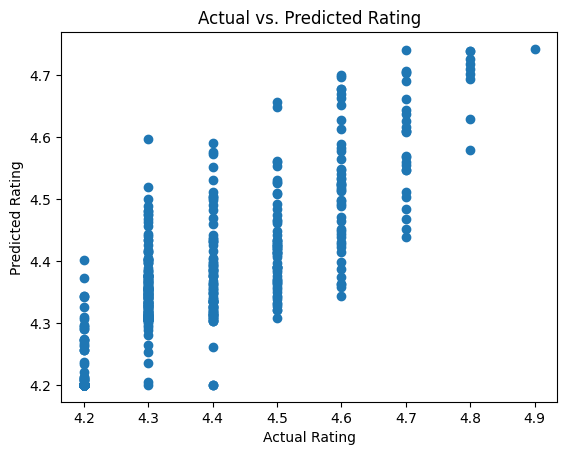

In [6]:
# Visualize the data (if applicable)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Rating')
plt.show()

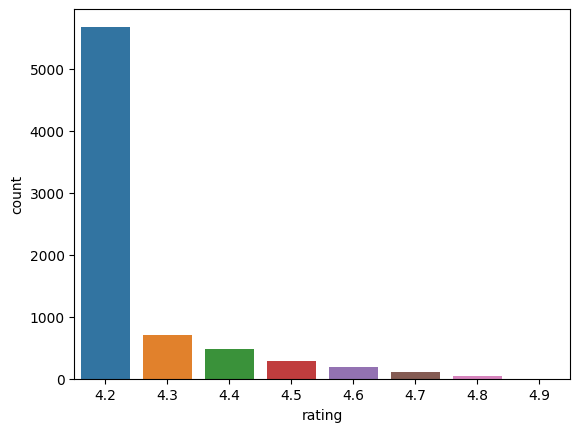

In [7]:
sns.countplot(x='rating', data=wine)
plt.show()

## **Model Optimization**

In [ ]:
# Define the parameter grid for the random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest regressor
reg_model = RandomForestRegressor()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(reg_model, param_distributions=param_grid, cv=5, n_iter=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_preprocessed, y_train)

# Get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Train the best model
best_model.fit(X_train_preprocessed, y_train)

# Make predictions with the best model
y_pred = best_model.predict(X_test_preprocessed)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

## **Feature Importance**

In [ ]:
# Retrieve feature importances
importance = best_model.feature_importances_
feature_names = numeric_cols + preprocessor.transformers_[1][1].get_feature_names_out().tolist()

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the results in a tabular format
print(tabulate(feature_importance_df, headers='keys', tablefmt='psql'))


## **Additional Data Exploration**

In [ ]:
# correlation heatmap
corr_matrix = wine.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## **Handling Class Imbalance**

In [ ]:
# SMOTE for oversampling the minority class
# Generate a synthetic imbalanced dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.95],
    flip_y=0,
    random_state=42)

# Instantiate the SMOTE oversampler
smote = SMOTE(random_state=42)

# Apply SMOTE to oversample the minority class
X_oversampled, y_oversampled = smote.fit_resample(X, y)

# Check the class distribution after oversampling
class_counts = np.bincount(y_oversampled)
print("Class distribution after oversampling:")
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count} samples")

## **Further Preprocessing**

In [ ]:
print(wine.columns)

In [ ]:
numeric_cols = ['rating', 'num_reviews', 'price', 'body', 'acidity']

Q1 = wine[numeric_cols].quantile(0.25)
Q3 = wine[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (wine[numeric_cols] < lower_bound) | (wine[numeric_cols] > upper_bound)
outliers_any = outliers.any(axis=1)

wine_no_outliers = wine[~outliers_any]

print(wine_no_outliers)

In [ ]:
print("Feature Importance Analysis:\n")

# Add these lines before printing the DataFrame
feature_importance_df.columns = [col.capitalize() for col in feature_importance_df.columns]  # Capitalize column names
print(feature_importance_df.to_string(index=False))

# Add these lines before printing the DataFrame
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(4)  # Round importance values to 4 decimal places
print(feature_importance_df.to_string(index=False))

# Add these lines before printing the DataFrame
feature_importance_df.columns = ['Feature', 'Importance']  # Rename columns with appropriate titles
print(feature_importance_df.to_string(index=False))